# This notebook will experiment on cifar-10 dataset with VGG-11 achitecture. It will generate a bunch of pickle files which are necessary variables for the notebook "plot_figures.ipynb"

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Constants (parameters) initialization

In [55]:
device_id = 0
num_workers = 4

batch_size = 4
# default_learning_rate = 0.1

## CIFAR-10 data load and preproc

In [56]:
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torch.utils.data.sampler import Sampler
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display

In [57]:
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure you are using the right device.

In [58]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [59]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items
        
    def __getitem__(self, idx):
        return self.dataset.__getitem__(idx)
    
    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [60]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose([transforms.ToTensor(), normalize])
val_transform = transforms.Compose([transforms.ToTensor(), normalize])

dataset_train = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='.', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
dataset_train_part = PartialDataset(dataset_train, 5000)
train_loader_part = DataLoader(dataset_train_part, batch_size=batch_size, shuffle=True, 
                               num_workers=num_workers)

dataset_val_part = PartialDataset(dataset_val, 1000)
val_loader_part = DataLoader(dataset_val_part, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Make sure that dataloader works as expected by observing one sample from it.

## Models implementation

In [63]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()
        
    return parameters_n

In [64]:
class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
       

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x
    
class VGG_A_Batch(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
       
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x
    
    
class VGG_A_Group(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(16, 256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(16, 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.GroupNorm(32, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
       

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

    
print(get_number_of_parameters(VGG_A()))

9750922


## Final preparations for training

In [65]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [66]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [67]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None,
          stage_layer=4,
          model_type='no'):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    losses_list = []
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()
        loss_list = []
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:
            
            #print(data)
            
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[stage_layer].weight.grad.clone())
            optimizer.step()
            
        grads.append(grad)
        losses_list.append(loss_list)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    plt.savefig(os.path.join('figs', 'batch_'+str(batch_size)+'_'+model_type+'_acc.png'), dpi=500, quality=100)
    return losses_list, grads

## Training

In [68]:
epo = 30
lr_1 = 0.0001
lr_2 = 0.0005
lr_3 = 0.00002

## No norm

lr_1

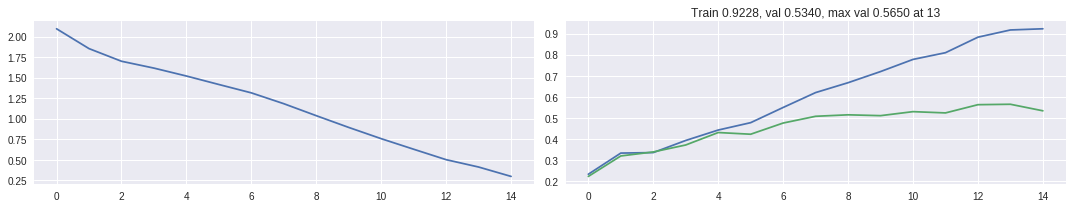


 50%|█████     | 15/30 [11:19<11:19, 45.27s/epoch]

In [ ]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_1)
criterion = nn.CrossEntropyLoss()

lg_no_01 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      model_type='no')

lr_2

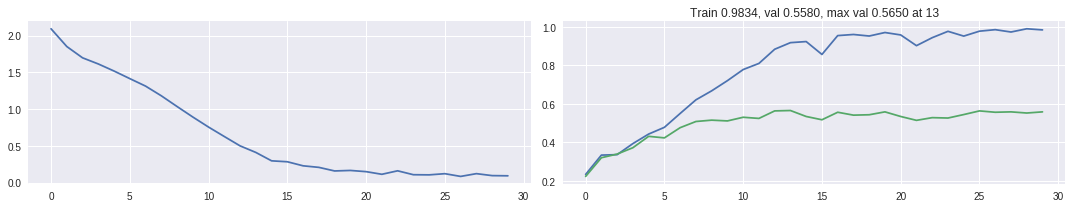


100%|██████████| 30/30 [22:31<00:00, 44.99s/epoch]

In [17]:
# os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_2)
criterion = nn.CrossEntropyLoss()

lg_no_02 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      model_type='no')

lr_3

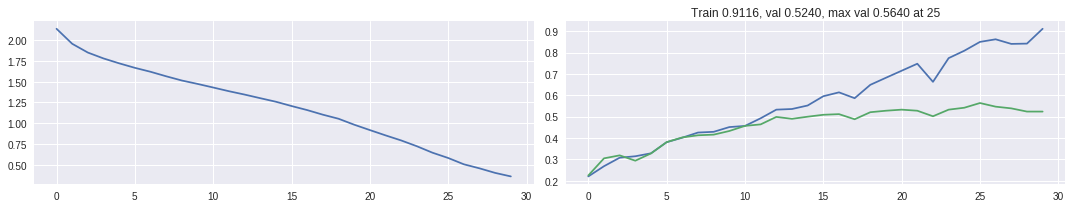


100%|██████████| 30/30 [22:33<00:00, 45.09s/epoch]

In [18]:
# os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_3)
criterion = nn.CrossEntropyLoss()

lg_no_03 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      model_type='no')

## Batch norm

lr_1

In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_1)
criterion = nn.CrossEntropyLoss()

lg_batch_01 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='bn')

lr_2

In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_2)
criterion = nn.CrossEntropyLoss()

lg_batch_02 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='bn')

lr_3

In [ ]:
# set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_3)
criterion = nn.CrossEntropyLoss()

lg_batch_03 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='bn')

## Group norm

lr_1

In [ ]:
# set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Group()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_1)
criterion = nn.CrossEntropyLoss()

lg_group_01 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='gn')

lr_2

In [ ]:
# set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Group()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_2)
criterion = nn.CrossEntropyLoss()

lg_group_02 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='gn')

lr_3

In [ ]:
# set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Group()
optimizer = torch.optim.Adam(model.parameters(), lr = lr_3)
criterion = nn.CrossEntropyLoss()

lg_group_03 = train(model, 
      optimizer, 
      criterion, 
      train_loader_part,
      val_loader_part,
      epochs_n=epo,
      stage_layer=6,
      model_type='gn')

## Write loss to files

In [20]:
import pickle
root = '128'

# group norm
with open(root+'gn_'+str(lr_1)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_group_01[0]).flatten()), list(np.array(lg_group_01[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'gn_'+str(lr_2)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_group_02[0]).flatten()), list(np.array(lg_group_02[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'gn_'+str(lr_3)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_group_03[0]).flatten()), list(np.array(lg_group_03[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
# batch norm
with open(root+'bn_'+str(lr_1)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_batch_01[0]).flatten()), list(np.array(lg_batch_01[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'bn_'+str(lr_2)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_batch_02[0]).flatten()), list(np.array(lg_batch_02[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'bn_'+str(lr_3)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_batch_03[0]).flatten()), list(np.array(lg_batch_03[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
# no norm
with open(root+'std_'+str(lr_1)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_no_01[0]).flatten()), list(np.array(lg_no_01[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'std_'+str(lr_2)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_no_02[0]).flatten()), list(np.array(lg_no_02[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)
    
with open(root+'std_'+str(lr_3)+'_'+str(batch_size)+'.pickle', 'wb') as f:
    tmp = (list(np.array(lg_no_03[0]).flatten()), list(np.array(lg_no_03[1]).flatten()))
    pickle.dump(tmp, f, pickle.HIGHEST_PROTOCOL)

# End